**Zero cost Zero time Zero shot: ZZZ Financial Sentiment Analysis**

Hugging Face's Moritz Laurer demonstrated in a great [blog](https://huggingface.co/blog/synthetic-data-save-costs) how to utilize pseudo-labeling data to achieve GPT-4 like performance with significantly reduced budget, carbon emission, and inference time. In practice, Moritz distilled Mixtral's knowledge into RoBERTa using a zero-shot text classification prompt and achieved no accuracy loss. In this post, we will try to take this work one step further and utilize extreme compression of 5-6 orders of magnitude without any accuracy loss. We will show how you can run simple MLP (Multilayer Perceptron) neural network (zero time) on low-resource device (zero cost) and achieve GPT-4 like performance without any labeled data (zero shot). We will demonstrate it on a financial sentiment analysis task.

Init

In [ ]:
!pip install datasets==2.18.0  # for loading the example dataset
!pip install scikit-learn  # for evaluation metrics

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score,classification_report
import numpy as np
import pandas as pd
import random
from datasets import load_dataset, Dataset
from setfit import SetFitModel, Trainer, TrainingArguments

Load Mixtral pseudo-labeling data from Hugging Face's Moritz Laurer GitHub https://github.com/MoritzLaurer/synthetic-data-blog/tree/main

In [ ]:
test_df = pd.read_csv('https://raw.githubusercontent.com/MoritzLaurer/synthetic-data-blog/main/data/df_test_HF_2024-02-06-21-57_mixtral.csv')
test_df.head()

train_df = pd.read_csv('https://raw.githubusercontent.com/MoritzLaurer/synthetic-data-blog/main/data/df_train_HF_2024-02-06-21-57_mixtral.csv')
train_df.head()

test_dataset = Dataset.from_dict({"text": test_df['text'], "label": test_df['label_experts']})  # Expert labeling
train_dataset = Dataset.from_dict({"text": train_df["text"], "label": train_df['label_llm_cot_multiple']}) # Pseudo labeling Mixtral CoT+SC

In [ ]:
test_df.head()

,sc_iter1,sc_iter2,sc_iter3,label_llm_cot_multiple,label_llm_cot,label_llm,label_experts,text,reason_iter1,reason_iter2,reason_iter3
0,negative,negative,negative,negative,negative,negative,negative,"In Q2 of 2009 , profit before taxes amounted t...",The text mentions a decrease in profit before ...,A decrease in profit before taxes from 26.8 mn...,The text mentions a decrease in profit before ...
1,neutral,neutral,neutral,neutral,neutral,neutral,neutral,To check them out or to make a bid they will b...,The text only mentions an event but no positiv...,The text does not mention any investment relev...,The text only mentions logistical information ...
2,positive,positive,positive,positive,positive,positive,positive,Operating profit surged to EUR21m from EUR106 ...,The text states an increase in operating profi...,An increase in operating profit from a low bas...,An increase in operating profit by several ord...
3,negative,negative,negative,negative,negative,negative,negative,Operating profit fell to EUR 20.3 mn from EUR ...,A decrease in operating profit is negative for...,Operating profit decreased significantly from ...,Operating profit fell by over 70% which is a s...
4,neutral,neutral,neutral,neutral,neutral,neutral,neutral,The contract also includes cutting and edging ...,The text only mentions a contract without any ...,The text only describes a business contract wi...,The text is only informational and does not ex...


Figure1: Zero-Shot Financial sentiment detection performance (https://huggingface.co/blog/synthetic-data-save-costs). zeroshot for the 3 generative LLMs and a fine-tuned RoBERTa based on the zeroshot pseudo-labeled data from Mixtral (CoT + SC) (1800~ data rows/texts)

 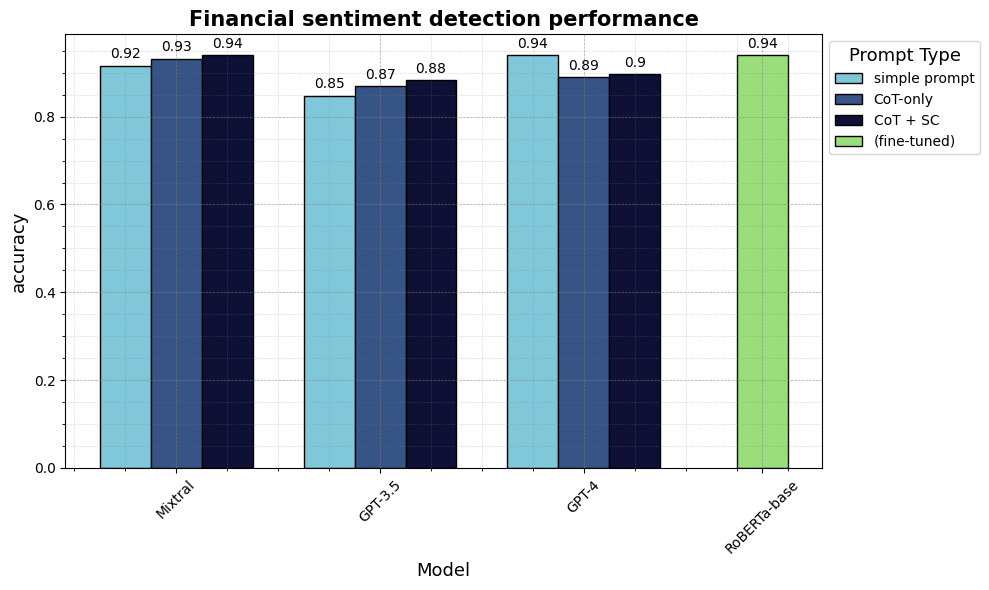

Train SetfIt with Mixtral pseudo-labeling data

The 'bge-small-en-v1.5' model includes only 30M parameters compared to RoBERTa-base's 130M.

In [ ]:
model = SetFitModel.from_pretrained("BAAI/bge-small-en-v1.5")

args = TrainingArguments(
    num_iterations = 5    # Modify the few-shot defualt value
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)
trainer.train()

metrics = trainer.evaluate()
print(metrics)

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/1811 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 18110
  Batch size = 16
  Num epochs = 1
  Total optimization steps = 1132


Step,Training Loss


***** Running evaluation *****


{'accuracy': 0.9381898454746137}


Question

**Question**: Is it possible to further distill to a tiny MLP model (~1M parameters and even lower) without any accuracy loss?

If yes, it means that we can deploy a model that produces GPT-4 performance on tiny devices such as smart watch.

Following my blog "[Best Practices for Text Classification](https://www.linkedin.com/pulse/best-practices-text-classification-distillation-part-34-wasserblat/)" we need first to estimate the Word Order Sensitivity (WOS) of the dataset.

If the WOS is relatively small it means that the prediction is not sensitive to word order hence a non-contextual model like MLP should be sufficient.     

Calculate Word Order Sensitivity (see more details by [Thang et al.](https://arxiv.org/pdf/2012.15180.pdf))

In [ ]:
x_test = test_dataset['text']
y_test = test_dataset['label']

label2num = {
  'negative': 0,
  'neutral': 1,
  'positive': 2
}

y_test_num = np.array([label2num[l] for l in y_test])

In [ ]:
# Regenerate random shuffling
x_test_sh = []
for sen in x_test:
  sen_list = sen.split(' ')
  random.shuffle(sen_list)
  x_test_sh.append(' '.join(sen_list))

In [ ]:
# No shuffle test Accuracy
pred_scores = model.predict_proba(x_test)
pred_bin = np.argmax(pred_scores,1)
print('No shuffle test accuracy is {:0.2f}.\n'.format(accuracy_score(pred_bin, y_test_num)))

# Shuffle test Accuracy
pred_scores_sh = model.predict_proba(x_test_sh)
pred_bin_sh = np.argmax(pred_scores_sh,1)
print('Shuffle test accuracy is {:0.2f}.\n'.format(accuracy_score(pred_bin_sh, y_test_num)))

No shuffle test accuracy is 0.94.

Shuffle test accuracy is 0.84.



In [ ]:
# SetFit True and Negative positive indexes
True_test_idx = [i for i, x in enumerate(y_test_num==pred_bin.numpy()) if x]

# SetFit's p shuffle on of the above
p=accuracy_score(list(np.array(y_test_num)[True_test_idx]), list(np.array(pred_bin_sh)[True_test_idx]))

num_labels=3
t=100-100/num_labels
WOS=(100-p*100)/t
print('WOS is {:0.3f}.\n'.format(WOS))
print('The WOS implies that in average {:0.1f}% of the sentences in the Finacial Sentiment Analysis (FSA) dataset are rather simple.\n'.format(100-100*WOS))

WOS is 0.197.

The WOS implies that in average 80.3% of the sentences in the FSA dataset are rather simple.



Great, we got relatively small value of WOS (<0.2),  so let's try to train an MLP based on Mixtral's pseudo-labeling

Train the MLP using Mixtral pseudo-labeling data

In [ ]:
x_train = train_dataset['text']
y_train = train_dataset['label']

In [ ]:
# sklearn's MLP
model_mlp = make_pipeline(CountVectorizer(ngram_range=(1,1), max_features=5000), MLPClassifier(random_state=1,early_stopping=True,hidden_layer_sizes=(64))).fit(x_train, y_train)
predicted = model_mlp.predict(x_test)
print(accuracy_score(y_test, predicted))
print(classification_report(y_test, predicted))

0.8167770419426048
              precision    recall  f1-score   support

    negative       0.71      0.64      0.67        61
     neutral       0.84      0.97      0.90       265
    positive       0.80      0.59      0.68       127

    accuracy                           0.82       453
   macro avg       0.78      0.73      0.75       453
weighted avg       0.81      0.82      0.81       453



Woops, not what we expected!
<82% accuracy is nice but substantially far from a GPT4/Mixtral performance

What went wrong?

Two major issues:
1. The teacher (Mixtral) model pseudo labels are hard descisions (integer numbers that represent the classes) rather than soft decisions (probabilities).
This limits the ability of the MLP (the student) to mimic Mixtral (the teacher)
in Moritz Laurer's blog Mixtral/GPT4 produces only hard decision. It was ok for a relatively large models like RoBERTa/SetFit but not sufficient for a tiny model such as MLP.

2. Usually distillation into tiny models requires much more pseudo labeled data for training.

Solution: We can try to generate soft decision with GPT4/mixtral and this time also augment with more available un-labeled data. But GPT4/Mixtral regeneration is time consuming, need proper prompts design, on top of that the quality of GPT4/Mixtral produced prbabilities is doubtful. Other much simpler solution would be to utilize the distilled SetFit (or RoBERTa) model to generate  prediction probabilities.     


Train MLP with SetFit prediction probabilities data

In [ ]:
# Utilaize the full Financial data that is available from Hugging Face's Hub.
dataset = load_dataset("financial_phrasebank", "sentences_50agree", split='train')

In [ ]:
# Assign only the text data. We don't care about the human labels since SetFit will generate the pseudo prediction probabilities.
x_train_50agree = dataset['sentence']

In [ ]:
# Predict probabilities (generate with the distilled SetFit)
y_train_50agree_predict = model.predict_proba(x_train_50agree)

In [ ]:
# Train MLP with the predicted probabilities
# Please note that this time we utilaize sklearn\MLPRegressor since we need to mimic the teacher soft decision (not the numeric labels)
# Note that we are testing 2 versions of MLP  - 128K params and 1.28M params.
from sklearn.neural_network import MLPRegressor
model_mlp_x = make_pipeline(CountVectorizer(ngram_range=(1,1), max_features=5000), MLPRegressor(random_state=1, early_stopping=True,hidden_layer_sizes=(256))).fit(x_train_50agree, y_train_50agree_predict)
predicted = model_mlp_x.predict(x_test)
print(accuracy_score(y_test_num, np.argmax(predicted, axis=1)))
print(classification_report(y_test_num, np.argmax(predicted, axis=1)))

0.9403973509933775
              precision    recall  f1-score   support

           0       0.89      0.93      0.91        61
           1       0.96      0.97      0.96       265
           2       0.93      0.89      0.91       127

    accuracy                           0.94       453
   macro avg       0.93      0.93      0.93       453
weighted avg       0.94      0.94      0.94       453



**Results:**

hidden_layer_sizes = 128

max_features=1000

Accuracy = 93

Model Size 128K

***

hidden_layer_sizes = 256

max_features=5000

Accuracy = 94

Model Size 1.28M parametrs

Nice. We were able to achieve Mixtral/GPT-4 performance with a tiny MLP model (:

MLP is super fast for inference and training on CPU, running on your edge device (marginal cost) and human labels are not needed (zero shot).  

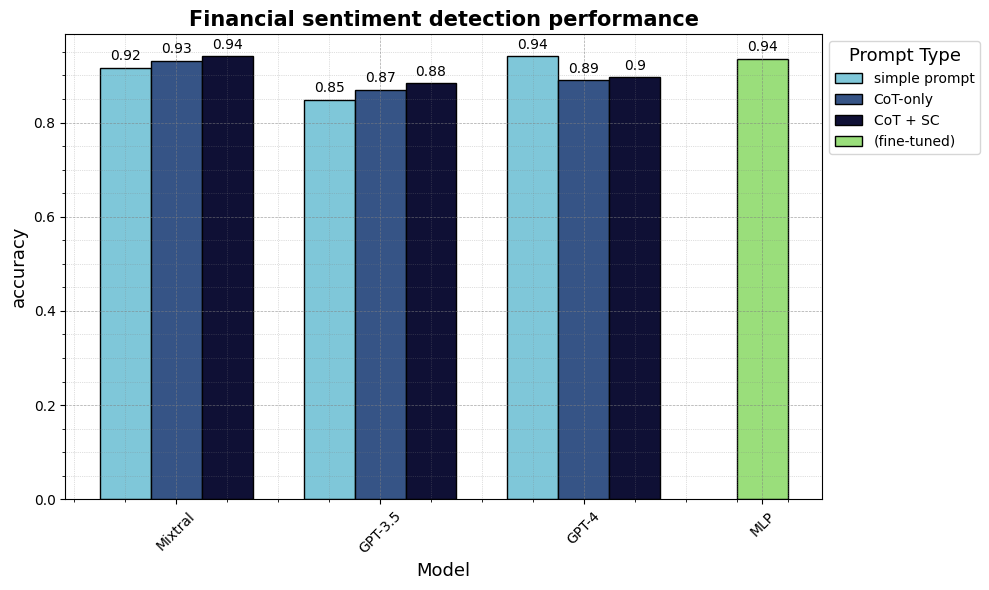


Performance Summary vs. Model size (# of parameters)

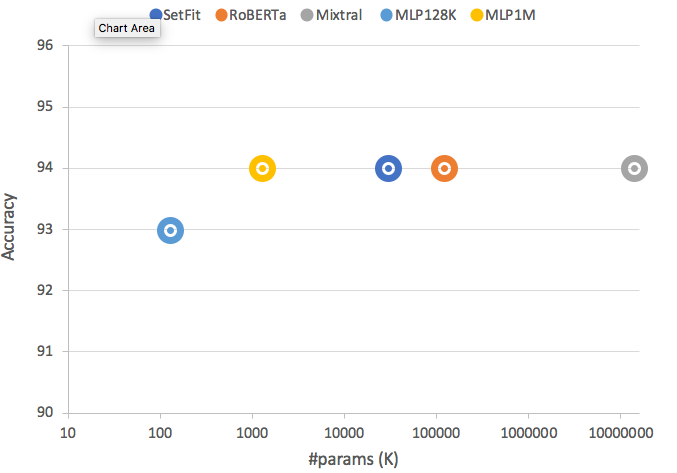